In [ ]:
!pip install chemprop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import chemprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/HAKATON/Final task'

In [ ]:
import pandas as pd
df_input = pd.read_csv(os.path.join(path, "HDAC6_clear.tsv"), sep='\t')

In [ ]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

from chemprop import data, featurizers, models, nn

In [ ]:
chemprop_dir = Path.cwd().parent
# input_path = chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'Ligand SMILES' # name of the column containing SMILES strings
target_columns = ['pIC50'] # list of names of the columns containing targets

In [ ]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [ ]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

In [ ]:
# available split types
list(data.SplitType.keys())

['SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

In [ ]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

In [ ]:
help(data.make_split_indices)

Help on function make_split_indices in module chemprop.data.splitting:

make_split_indices(mols: collections.abc.Sequence[rdkit.Chem.rdchem.Mol], split: chemprop.data.splitting.SplitType | str = 'random', sizes: tuple[float, float, float] = (0.8, 0.1, 0.1), seed: int = 0, num_replicates: int = 1, num_folds: None = None) -> tuple[list[list[int]], ...]
    Splits data into training, validation, and test splits.
    
    Parameters
    ----------
    mols : Sequence[Chem.Mol]
        Sequence of RDKit molecules to use for structure based splitting
    split : SplitType | str, optional
        Split type, one of ~chemprop.data.utils.SplitType, by default "random"
    sizes : tuple[float, float, float], optional
        3-tuple with the proportions of data in the train, validation, and test sets, by default
        (0.8, 0.1, 0.1). Set the middle value to 0 for a two way split.
    seed : int, optional
        The random seed passed to astartes, by default 0
    num_replicates : int, option

In [ ]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer)

In [ ]:
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

In [ ]:
mp = nn.BondMessagePassing()

In [ ]:
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [ ]:
agg = nn.MeanAggregation()

In [ ]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [ ]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

In [ ]:
ffn = nn.RegressionFFN(output_transform=output_transform)

In [ ]:
batch_norm = True

In [ ]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


In [ ]:
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()] # Only the first metric is used for training and early stopping


In [ ]:
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weigh

In [ ]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)


trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100, # number of epochs to train for
    callbacks=[checkpointing], # Use the configured checkpoint callback
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(mpnn, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
results = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/checkpoints/best-epoch=84-val_loss=0.33.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-epoch=84-val_loss=0.33.ckpt
INFO: Loaded model weights from the checkpoint at /content/checkpoints/best-epoch=84-val_loss=0.33.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-epoch=84-val_loss=0.33.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.44040608406066895    │
│          test/r2          │    0.6465134620666504     │
│         test/rmse         │     0.621912956237793     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_indices

[[np.int64(2712),
  np.int64(3511),
  np.int64(1201),
  np.int64(4260),
  np.int64(424),
  np.int64(4421),
  np.int64(3715),
  np.int64(664),
  np.int64(350),
  np.int64(447),
  np.int64(709),
  np.int64(1924),
  np.int64(1221),
  np.int64(3922),
  np.int64(2766),
  np.int64(387),
  np.int64(3547),
  np.int64(1337),
  np.int64(4547),
  np.int64(4795),
  np.int64(3205),
  np.int64(1608),
  np.int64(830),
  np.int64(5346),
  np.int64(3418),
  np.int64(1734),
  np.int64(5350),
  np.int64(5306),
  np.int64(1006),
  np.int64(400),
  np.int64(1253),
  np.int64(21),
  np.int64(1305),
  np.int64(237),
  np.int64(3107),
  np.int64(3665),
  np.int64(671),
  np.int64(845),
  np.int64(4790),
  np.int64(4902),
  np.int64(1353),
  np.int64(5188),
  np.int64(3451),
  np.int64(869),
  np.int64(3686),
  np.int64(604),
  np.int64(4723),
  np.int64(3868),
  np.int64(902),
  np.int64(2904),
  np.int64(1747),
  np.int64(3310),
  np.int64(2051),
  np.int64(4047),
  np.int64(3928),
  np.int64(2757),
  np.int

In [ ]:
[int(x) for x in test_indices[0]]

[2712,
 3511,
 1201,
 4260,
 424,
 4421,
 3715,
 664,
 350,
 447,
 709,
 1924,
 1221,
 3922,
 2766,
 387,
 3547,
 1337,
 4547,
 4795,
 3205,
 1608,
 830,
 5346,
 3418,
 1734,
 5350,
 5306,
 1006,
 400,
 1253,
 21,
 1305,
 237,
 3107,
 3665,
 671,
 845,
 4790,
 4902,
 1353,
 5188,
 3451,
 869,
 3686,
 604,
 4723,
 3868,
 902,
 2904,
 1747,
 3310,
 2051,
 4047,
 3928,
 2757,
 5342,
 4417,
 696,
 1179,
 4720,
 5185,
 2173,
 1090,
 848,
 1769,
 3808,
 4876,
 3745,
 605,
 174,
 2269,
 2463,
 100,
 1243,
 741,
 334,
 2908,
 2881,
 3292,
 3463,
 4690,
 2987,
 4702,
 4423,
 4043,
 5165,
 4736,
 1468,
 1838,
 3123,
 3674,
 460,
 1562,
 1975,
 3290,
 4515,
 738,
 1438,
 497,
 2750,
 3945,
 375,
 1209,
 404,
 3778,
 2467,
 93,
 3513,
 3204,
 2221,
 1849,
 827,
 4524,
 3187,
 4378,
 343,
 2683,
 2786,
 2547,
 3146,
 691,
 0,
 1582,
 1707,
 2021,
 3221,
 3591,
 2003,
 1131,
 5146,
 3717,
 2304,
 5082,
 2375,
 3395,
 2261,
 1731,
 1159,
 4342,
 2120,
 5106,
 2685,
 1671,
 5152,
 3273,
 1971,
 4461,


In [ ]:
test_strings = df_input.iloc[[int(x) for x in test_indices[0]]]
test_strings = test_strings[['Ligand SMILES', 'pIC50']]
test_strings

,Ligand SMILES,pIC50
2712,FC(F)c1nnc(o1)-c1ccn(CCOc2cc(F)cc(F)c2)c(=O)c1,-0.477121
3511,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@@H]2C[C@](C)(...,-1.000000
1201,COc1ccc(CNC(=O)c2ccc(s2)C(=O)C(F)(F)F)cc1,-2.380211
4260,Fc1cc(F)c(OCc2ccc(-c3noc(n3)C(F)(F)F)c(F)c2)cn1,-1.431364
424,CCNC(=O)N(Cc1ccc(cc1)-c1noc(n1)C(F)(F)F)c1cccc...,-1.963788
...,...,...
3264,FC(F)(F)c1nc(no1)-c1ccc(COc2cccc3[nH]nnc23)nc1,-0.785330
1653,ONC(=O)CCCCCCn1cc(C(=O)NC2CCCCC2)c2ccccc12,-0.361728
2607,CC[C@H]1OC(=O)[C@@H](C)[C@H](O[C@H]2C[C@@](C)(...,-3.752816
2732,ONC(=O)c1ccc(CN2CCc3cccnc23)cc1,-0.505150


In [ ]:
import torch

In [ ]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="cpu",
        devices=1
    )
    test_preds = trainer.predict(mpnn, test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import numpy as np

In [ ]:
test_preds = np.concatenate(test_preds, axis=0)
test_strings['pred'] = test_preds
test_strings

,Ligand SMILES,pIC50,pred
2712,FC(F)c1nnc(o1)-c1ccn(CCOc2cc(F)cc(F)c2)c(=O)c1,-0.477121,-1.209266
3511,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@@H]2C[C@](C)(...,-1.000000,-1.460192
1201,COc1ccc(CNC(=O)c2ccc(s2)C(=O)C(F)(F)F)cc1,-2.380211,-2.921502
4260,Fc1cc(F)c(OCc2ccc(-c3noc(n3)C(F)(F)F)c(F)c2)cn1,-1.431364,-1.850208
424,CCNC(=O)N(Cc1ccc(cc1)-c1noc(n1)C(F)(F)F)c1cccc...,-1.963788,-2.369270
...,...,...,...
3264,FC(F)(F)c1nc(no1)-c1ccc(COc2cccc3[nH]nnc23)nc1,-0.785330,-1.523263
1653,ONC(=O)CCCCCCn1cc(C(=O)NC2CCCCC2)c2ccccc12,-0.361728,-0.251257
2607,CC[C@H]1OC(=O)[C@@H](C)[C@H](O[C@H]2C[C@@](C)(...,-3.752816,-2.956873
2732,ONC(=O)c1ccc(CN2CCc3cccnc23)cc1,-0.505150,-0.551761


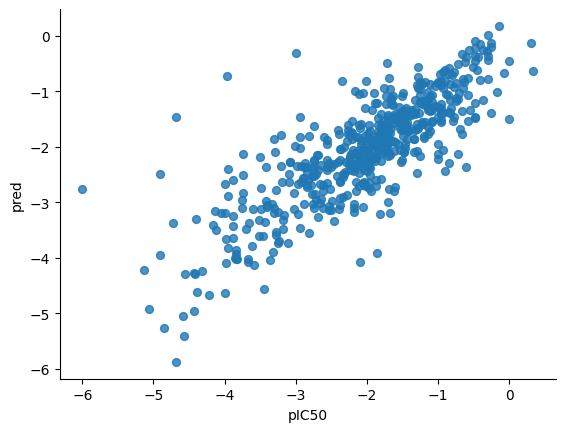

In [ ]:
# @title pIC50 vs pred

from matplotlib import pyplot as plt
test_strings.plot(kind='scatter', x='pIC50', y='pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)